In [1]:
# ============================================================================
# Aureus Sigma Capital - 2018-2025 Comparative Backtest
# Notebook: 03a_comparative_backtest_2018_2025.ipynb
#
# Description:
# This notebook executes a backtest for the exact 2018-2025 period to allow
# for a direct, apples-to-apples comparison with previous engine results.
# It uses the canonical engine and visualization from Notebook 03.
#
# Author: Duc Nguyen, Quantitative Finance Expert
# Date: July 26, 2025
# Version: 1.0 - Comparative Period
# ============================================================================

# Core imports (same as before)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import pickle
import warnings
from scipy import stats
from typing import Dict, List, Tuple, Optional

warnings.filterwarnings('ignore')

# --- INSTITUTIONAL PALETTE ---
FACTOR_COLORS = {
    'Strategy': '#16A085', 'Benchmark': '#34495E', 'Positive': '#27AE60',
    'Negative': '#C0392B', 'Drawdown': '#E67E22', 'Sharpe': '#2980B9',
    'Grid': '#BDC3C7', 'Text_Primary': '#2C3E50', 'Neutral': '#7F8C8D'
}
GRADIENT_PALETTES = {'performance': ['#C0392B', '#FFFFFF', '#27AE60']}

# --- VISUALIZATION CONFIGURATION ---
plt.style.use('default')
plt.rcParams.update({
    'figure.dpi': 300, 'savefig.dpi': 300, 'figure.figsize': (15, 8),
    'figure.facecolor': 'white', 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': FACTOR_COLORS['Text_Primary'],
    'axes.linewidth': 1.0, 'axes.grid': True, 'axes.axisbelow': True,
    'axes.labelcolor': FACTOR_COLORS['Text_Primary'], 'axes.titlesize': 14,
    'axes.titleweight': 'bold', 'axes.titlecolor': FACTOR_COLORS['Text_Primary'],
    'grid.color': FACTOR_COLORS['Grid'], 'grid.alpha': 0.3, 'grid.linewidth': 0.5,
    'legend.frameon': False, 'legend.fontsize': 10,
    'xtick.color': FACTOR_COLORS['Text_Primary'], 'ytick.color': FACTOR_COLORS['Text_Primary'],
    'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})
print("📊 Visualization environment configured for comparative backtest.")

# --- Master Strategy Configuration ---
# *** CRITICAL CHANGE: Set start date to 2018-01-01 ***
STRATEGY_CONFIG = {
    "backtest_start_date": "2018-01-01",
    "backtest_end_date": "2025-07-25",
    "selection_percentile": 0.20,
    "rebalance_freq": 'M',
    "long_only": True,
    "max_sector_weight": 0.40,
    "max_position_weight": 0.05,
    "transaction_cost_bps": 30
}

print("\n" + "=" * 70)
print("🚀 Aureus Sigma: 2018-2025 Comparative Backtest")
print(f"   Version: 1.0 - Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)
print("\n--- STRATEGY CONFIGURATION ---")
for key, value in STRATEGY_CONFIG.items():
    print(f"{key:<25}: {value}")
print("\n--- BACKTEST OBJECTIVE ---")
print("• To generate an apples-to-apples performance comparison against")
print("  results from the previous (monthly) backtesting engine.")
print("------------------------------")

📊 Visualization environment configured for comparative backtest.

🚀 Aureus Sigma: 2018-2025 Comparative Backtest
   Version: 1.0 - Date: 2025-07-26 16:48:08

--- STRATEGY CONFIGURATION ---
backtest_start_date      : 2018-01-01
backtest_end_date        : 2025-07-25
selection_percentile     : 0.2
rebalance_freq           : M
long_only                : True
max_sector_weight        : 0.4
max_position_weight      : 0.05
transaction_cost_bps     : 30

--- BACKTEST OBJECTIVE ---
• To generate an apples-to-apples performance comparison against
  results from the previous (monthly) backtesting engine.
------------------------------


In [2]:
# ============================================================================
# CELL 2: LOAD AND FILTER CORE DATA OBJECTS
# ============================================================================
# This version loads the full data objects and then applies a date filter
# to create the specific 2018-2025 analysis period.

import pandas as pd
import pickle
import yaml
from sqlalchemy import create_engine
from pathlib import Path
import sys

project_root = Path.cwd()
while not (project_root / 'production').exists() and not (project_root / 'config').exists():
    if project_root.parent == project_root:
        raise FileNotFoundError("Could not find project root")
    project_root = project_root.parent

data_path = project_root / "production" / "tests" / "phase7_institutional_backtesting"

print("📂 Loading core data objects from production directory...")

try:
    with open(data_path / "factor_data.pkl", "rb") as f:
        factor_data_obj = pickle.load(f)
    with open(data_path / "daily_returns.pkl", "rb") as f:
        returns_data_obj = pickle.load(f)
    with open(data_path / "benchmark_returns.pkl", "rb") as f:
        benchmark_data_obj = pickle.load(f)
    print("   ✅ All data objects loaded.")
    
    # Extract full datasets
    factor_data_full = factor_data_obj['data']
    daily_returns_full = returns_data_obj['data']
    benchmark_returns_full = benchmark_data_obj['data']

    # *** CRITICAL CHANGE: Filter data to the 2018-2025 period ***
    print(f"\n🔪 Filtering data to start from: {STRATEGY_CONFIG['backtest_start_date']}")
    start_date = pd.to_datetime(STRATEGY_CONFIG['backtest_start_date'])
    
    factor_data = factor_data_full[factor_data_full.index >= start_date]
    daily_returns = daily_returns_full[daily_returns_full.index >= start_date]
    benchmark_returns = benchmark_returns_full[benchmark_returns_full.index >= start_date]

    # --- Load and Clean Sector Info ---
    print("\n🏗️ Loading and cleaning sector information from master_info...")
    config_path = project_root / 'config' / 'database.yml'
    with open(config_path, 'r') as f:
        db_config = yaml.safe_load(f)['production']
    temp_engine = create_engine(
        f"mysql+pymysql://{db_config['username']}:{db_config['password']}@"
        f"{db_config['host']}/{db_config['schema_name']}"
    )
    sector_sql = "SELECT ticker, sector FROM master_info WHERE sector IS NOT NULL"
    sector_info_raw = pd.read_sql(sector_sql, temp_engine)
    sector_info = sector_info_raw.drop_duplicates(subset=['ticker']).set_index('ticker')
    temp_engine.dispose()
    print(f"   ✅ Sector mapping created for {len(sector_info)} unique tickers.")

    # --- Data Alignment ---
    common_index = factor_data.index.intersection(daily_returns.index).intersection(benchmark_returns.index)
    common_tickers = factor_data.columns.get_level_values(1).intersection(daily_returns.columns).unique().intersection(sector_info.index)
    
    qvm_scores = factor_data.loc[common_index, ('qvm_composite_score', common_tickers)]
    qvm_scores.columns = qvm_scores.columns.droplevel(0)
    
    daily_returns = daily_returns.loc[common_index, common_tickers]
    benchmark_returns = benchmark_returns.loc[common_index]
    
    print("\n🔗 Data Aligned for Comparative Backtest:")
    print(f"   Aligned date range: {common_index.min().date()} to {common_index.max().date()}")
    print(f"   Trading days: {len(common_index)}")
    print(f"   Universe size: {len(common_tickers)} stocks")

except Exception as e:
    print(f"❌ Error loading or aligning data: {e}")
    raise

📂 Loading core data objects from production directory...
   ✅ All data objects loaded.

🔪 Filtering data to start from: 2018-01-01

🏗️ Loading and cleaning sector information from master_info...
   ✅ Sector mapping created for 728 unique tickers.

🔗 Data Aligned for Comparative Backtest:
   Aligned date range: 2018-01-02 to 2025-07-25
   Trading days: 1881
   Universe size: 714 stocks


In [3]:
# ============================================================================
# CELL 3: CONSTRAINED PORTFOLIO CONSTRUCTION & BACKTESTING ENGINE (CORRECTED v1.3)
# ============================================================================
# This version corrects the ValueError by using a more robust and direct
# method for assigning portfolio weights, avoiding the problematic np.tile.

def construct_constrained_portfolio(
    factor_scores: pd.Series, 
    sector_info: pd.DataFrame, 
    config: dict
) -> pd.DataFrame:
    """
    Constructs a single, constrained portfolio for a given rebalance date.
    """
    if factor_scores.empty:
        return pd.DataFrame(columns=['weight', 'sector'])

    # Select top quintile of stocks
    top_quintile_cutoff = factor_scores.quantile(1 - config['selection_percentile'])
    selected_stocks_df = factor_scores[factor_scores >= top_quintile_cutoff].to_frame('factor_score')
    
    # Merge with sector information
    portfolio_df = selected_stocks_df.join(sector_info)
    
    # Handle potential missing sectors after join
    if portfolio_df['sector'].isnull().any():
        # Fallback: remove stocks with no sector info for constraint checking
        portfolio_df.dropna(subset=['sector'], inplace=True)

    if portfolio_df.empty:
        return pd.DataFrame(columns=['weight', 'sector'])

    # Apply sector constraints
    sector_counts = portfolio_df['sector'].value_counts()
    max_stocks_in_portfolio = len(portfolio_df)
    max_stocks_per_sector = int(max_stocks_in_portfolio * config['max_sector_weight'])
    
    final_tickers = set()
    for sector, count in sector_counts.items():
        sector_stocks = portfolio_df[portfolio_df['sector'] == sector]
        if count > max_stocks_per_sector and max_stocks_per_sector > 0:
            top_in_sector = sector_stocks.nlargest(max_stocks_per_sector, 'factor_score').index
            final_tickers.update(top_in_sector)
        else:
            final_tickers.update(sector_stocks.index)
            
    final_portfolio = portfolio_df.loc[list(final_tickers)].copy()
    
    # Assign equal weights
    num_stocks = len(final_portfolio)
    if num_stocks > 0:
        final_portfolio['weight'] = 1.0 / num_stocks
    else:
        return pd.DataFrame(columns=['weight', 'sector'])
        
    # Apply position weight cap
    max_pos_weight = config['max_position_weight']
    if final_portfolio['weight'].max() > max_pos_weight:
        print(f"  - WARNING: Equal weight {final_portfolio['weight'].max():.2%} exceeds max position weight {max_pos_weight:.1%}.")

    return final_portfolio[['weight', 'sector']]


def run_canonical_backtest(
    qvm_scores: pd.DataFrame,
    daily_returns: pd.DataFrame,
    sector_info: pd.DataFrame,
    config: dict
) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Runs the full vectorized backtest for the canonical QVM strategy.
    """
    print("🚀 Running Canonical Vectorized Backtest (v1.3 - Robust Assignment)...")
    
    # 1. IDENTIFY REBALANCE DATES
    ideal_rebalance_dates = pd.date_range(
        start=qvm_scores.index.min(), 
        end=qvm_scores.index.max(), 
        freq=config['rebalance_freq']
    )
    print(f"   - Identified {len(ideal_rebalance_dates)} ideal rebalance dates.")

    # 2. Construct Daily Holdings Matrix
    daily_holdings = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns).fillna(0.0)
    
    factor_scores_on_rebal_dates = qvm_scores.reindex(ideal_rebalance_dates, method='ffill')

    for i in range(len(factor_scores_on_rebal_dates.index)):
        rebal_date = factor_scores_on_rebal_dates.index[i]
        
        try:
            next_rebal_date = factor_scores_on_rebal_dates.index[i+1]
        except IndexError:
            next_rebal_date = daily_returns.index[-1] + pd.Timedelta(days=1)

        factor_scores_at_rebal = factor_scores_on_rebal_dates.loc[rebal_date].dropna()
        
        if len(factor_scores_at_rebal) > 20:
            portfolio_df = construct_constrained_portfolio(factor_scores_at_rebal, sector_info, config)
            
            if not portfolio_df.empty:
                # Define the holding period for this portfolio
                relevant_days = daily_returns.index[(daily_returns.index > rebal_date) & (daily_returns.index < next_rebal_date)]
                
                if not relevant_days.empty:
                    # *** CRITICAL FIX v1.3 ***
                    # Assign the weight Series to each relevant day. This is robust.
                    for day in relevant_days:
                        valid_tickers = portfolio_df.index.intersection(daily_holdings.columns)
                        daily_holdings.loc[day, valid_tickers] = portfolio_df.loc[valid_tickers, 'weight']

    print("   - Constructed daily holdings matrix.")

    # 3. PREVENT LOOK-AHEAD BIAS
    daily_holdings_shifted = daily_holdings.shift(1).fillna(0)
    print("   - Shifted holdings by 1 day to prevent look-ahead bias.")

    # 4. CALCULATE GROSS PORTFOLIO RETURNS
    gross_returns = (daily_holdings_shifted * daily_returns).sum(axis=1)
    print("   - Calculated daily gross returns.")

    # 5. MODEL TRANSACTION COSTS
    turnover = (daily_holdings_shifted - daily_holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    transaction_costs = turnover * (config['transaction_cost_bps'] / 10000)
    
    net_returns = gross_returns - transaction_costs
    print("   - Applied transaction costs to get net returns.")
    
    backtest_log = pd.DataFrame({
        'gross_return': gross_returns,
        'net_return': net_returns,
        'turnover': turnover,
        'transaction_cost': transaction_costs,
        'positions': (daily_holdings_shifted > 0).sum(axis=1)
    })

    print("✅ Canonical backtest complete.")
    return net_returns, backtest_log

print("✅ Constrained portfolio and backtesting engine defined (Corrected).")

✅ Constrained portfolio and backtesting engine defined (Corrected).


In [4]:
# ============================================================================
# CELL 4: EXECUTE CANONICAL BACKTEST
# ============================================================================
# This cell runs the main backtest function to generate the strategy's
# performance based on the QVM composite score.

print("🚀 Executing the canonical backtest for the QVM Combined strategy...")

# Run the backtest
strategy_net_returns, backtest_log = run_canonical_backtest(
    qvm_scores=qvm_scores,
    daily_returns=daily_returns,
    sector_info=sector_info,
    config=STRATEGY_CONFIG
)

# --- Initial Performance Validation ---
print("\n" + "="*70)
print("📊 Initial Performance Validation")
print("="*70)

if not strategy_net_returns.empty:
    # Calculate key performance metrics
    total_return = (1 + strategy_net_returns).prod() - 1
    n_years = len(strategy_net_returns) / 252
    annual_return = (1 + total_return) ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = strategy_net_returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - 0.0) / annual_vol if annual_vol > 0 else 0 # Assuming 0 risk-free rate

    print(f"   Backtest Period: {strategy_net_returns.index.min().date()} to {strategy_net_returns.index.max().date()}")
    print(f"   Total Trading Days: {len(strategy_net_returns)}")
    print("-" * 40)
    print(f"   Total Return: {total_return:.2%}")
    print(f"   Annualized Return: {annual_return:.2%}")
    print(f"   Annualized Volatility: {annual_vol:.2%}")
    print(f"   Sharpe Ratio: {sharpe_ratio:.2f}")
    print("-" * 40)
    
    # Validate against performance targets
    return_check = 0.21 <= annual_return <= 0.26
    sharpe_check = sharpe_ratio >= 1.45
    
    print("🎯 Validating against historical performance targets:")
    print(f"   Annual Return (21-26%): {'✅ PASS' if return_check else '❌ FAIL'}")
    print(f"   Sharpe Ratio (>1.45):   {'✅ PASS' if sharpe_check else '❌ FAIL'}")

    if return_check and sharpe_check:
        print("\n🎉 SUCCESS: Performance is consistent with historical expectations.")
    else:
        print("\n⚠️ WARNING: Performance deviates from historical expectations. Further analysis required.")
        
    # Display a preview of the backtest log
    print("\n📋 Backtest Log Preview:")
    display(backtest_log.head())
    
    print("\n📋 Backtest Log Statistics:")
    display(backtest_log.describe().round(4))

else:
    print("❌ Backtest execution failed to produce results.")

🚀 Executing the canonical backtest for the QVM Combined strategy...
🚀 Running Canonical Vectorized Backtest (v1.3 - Robust Assignment)...
   - Identified 90 ideal rebalance dates.
   - Constructed daily holdings matrix.
   - Shifted holdings by 1 day to prevent look-ahead bias.
   - Calculated daily gross returns.
   - Applied transaction costs to get net returns.
✅ Canonical backtest complete.

📊 Initial Performance Validation
   Backtest Period: 2018-01-02 to 2025-07-25
   Total Trading Days: 1881
----------------------------------------
   Total Return: 202.01%
   Annualized Return: 15.96%
   Annualized Volatility: 14.04%
   Sharpe Ratio: 1.14
----------------------------------------
🎯 Validating against historical performance targets:
   Annual Return (21-26%): ❌ FAIL
   Sharpe Ratio (>1.45):   ❌ FAIL

⚠️ WARNING: Performance deviates from historical expectations. Further analysis required.

📋 Backtest Log Preview:


,gross_return,net_return,turnover,transaction_cost,positions
2018-01-02,0.0,0.0,0.0,0.0,0
2018-01-03,0.0,0.0,0.0,0.0,0
2018-01-04,0.0,0.0,0.0,0.0,0
2018-01-05,0.0,0.0,0.0,0.0,0
2018-01-08,0.0,0.0,0.0,0.0,0



📋 Backtest Log Statistics:


,gross_return,net_return,turnover,transaction_cost,positions
count,1881.0000,1881.0000,1881.0000,1881.0000,1881.0000
mean,0.0007,0.0006,0.0338,0.0001,131.5635
std,0.0089,0.0088,0.1212,0.0004,27.5537
min,-0.0586,-0.0586,0.0000,0.0000,0.0000
25%,-0.0022,-0.0022,0.0000,0.0000,134.0000
50%,0.0013,0.0013,0.0000,0.0000,139.0000
75%,0.0049,0.0048,0.0000,0.0000,142.0000
max,0.0588,0.0588,0.5000,0.0015,143.0000


📊 Calculating final performance metrics and generating the canonical tearsheet...


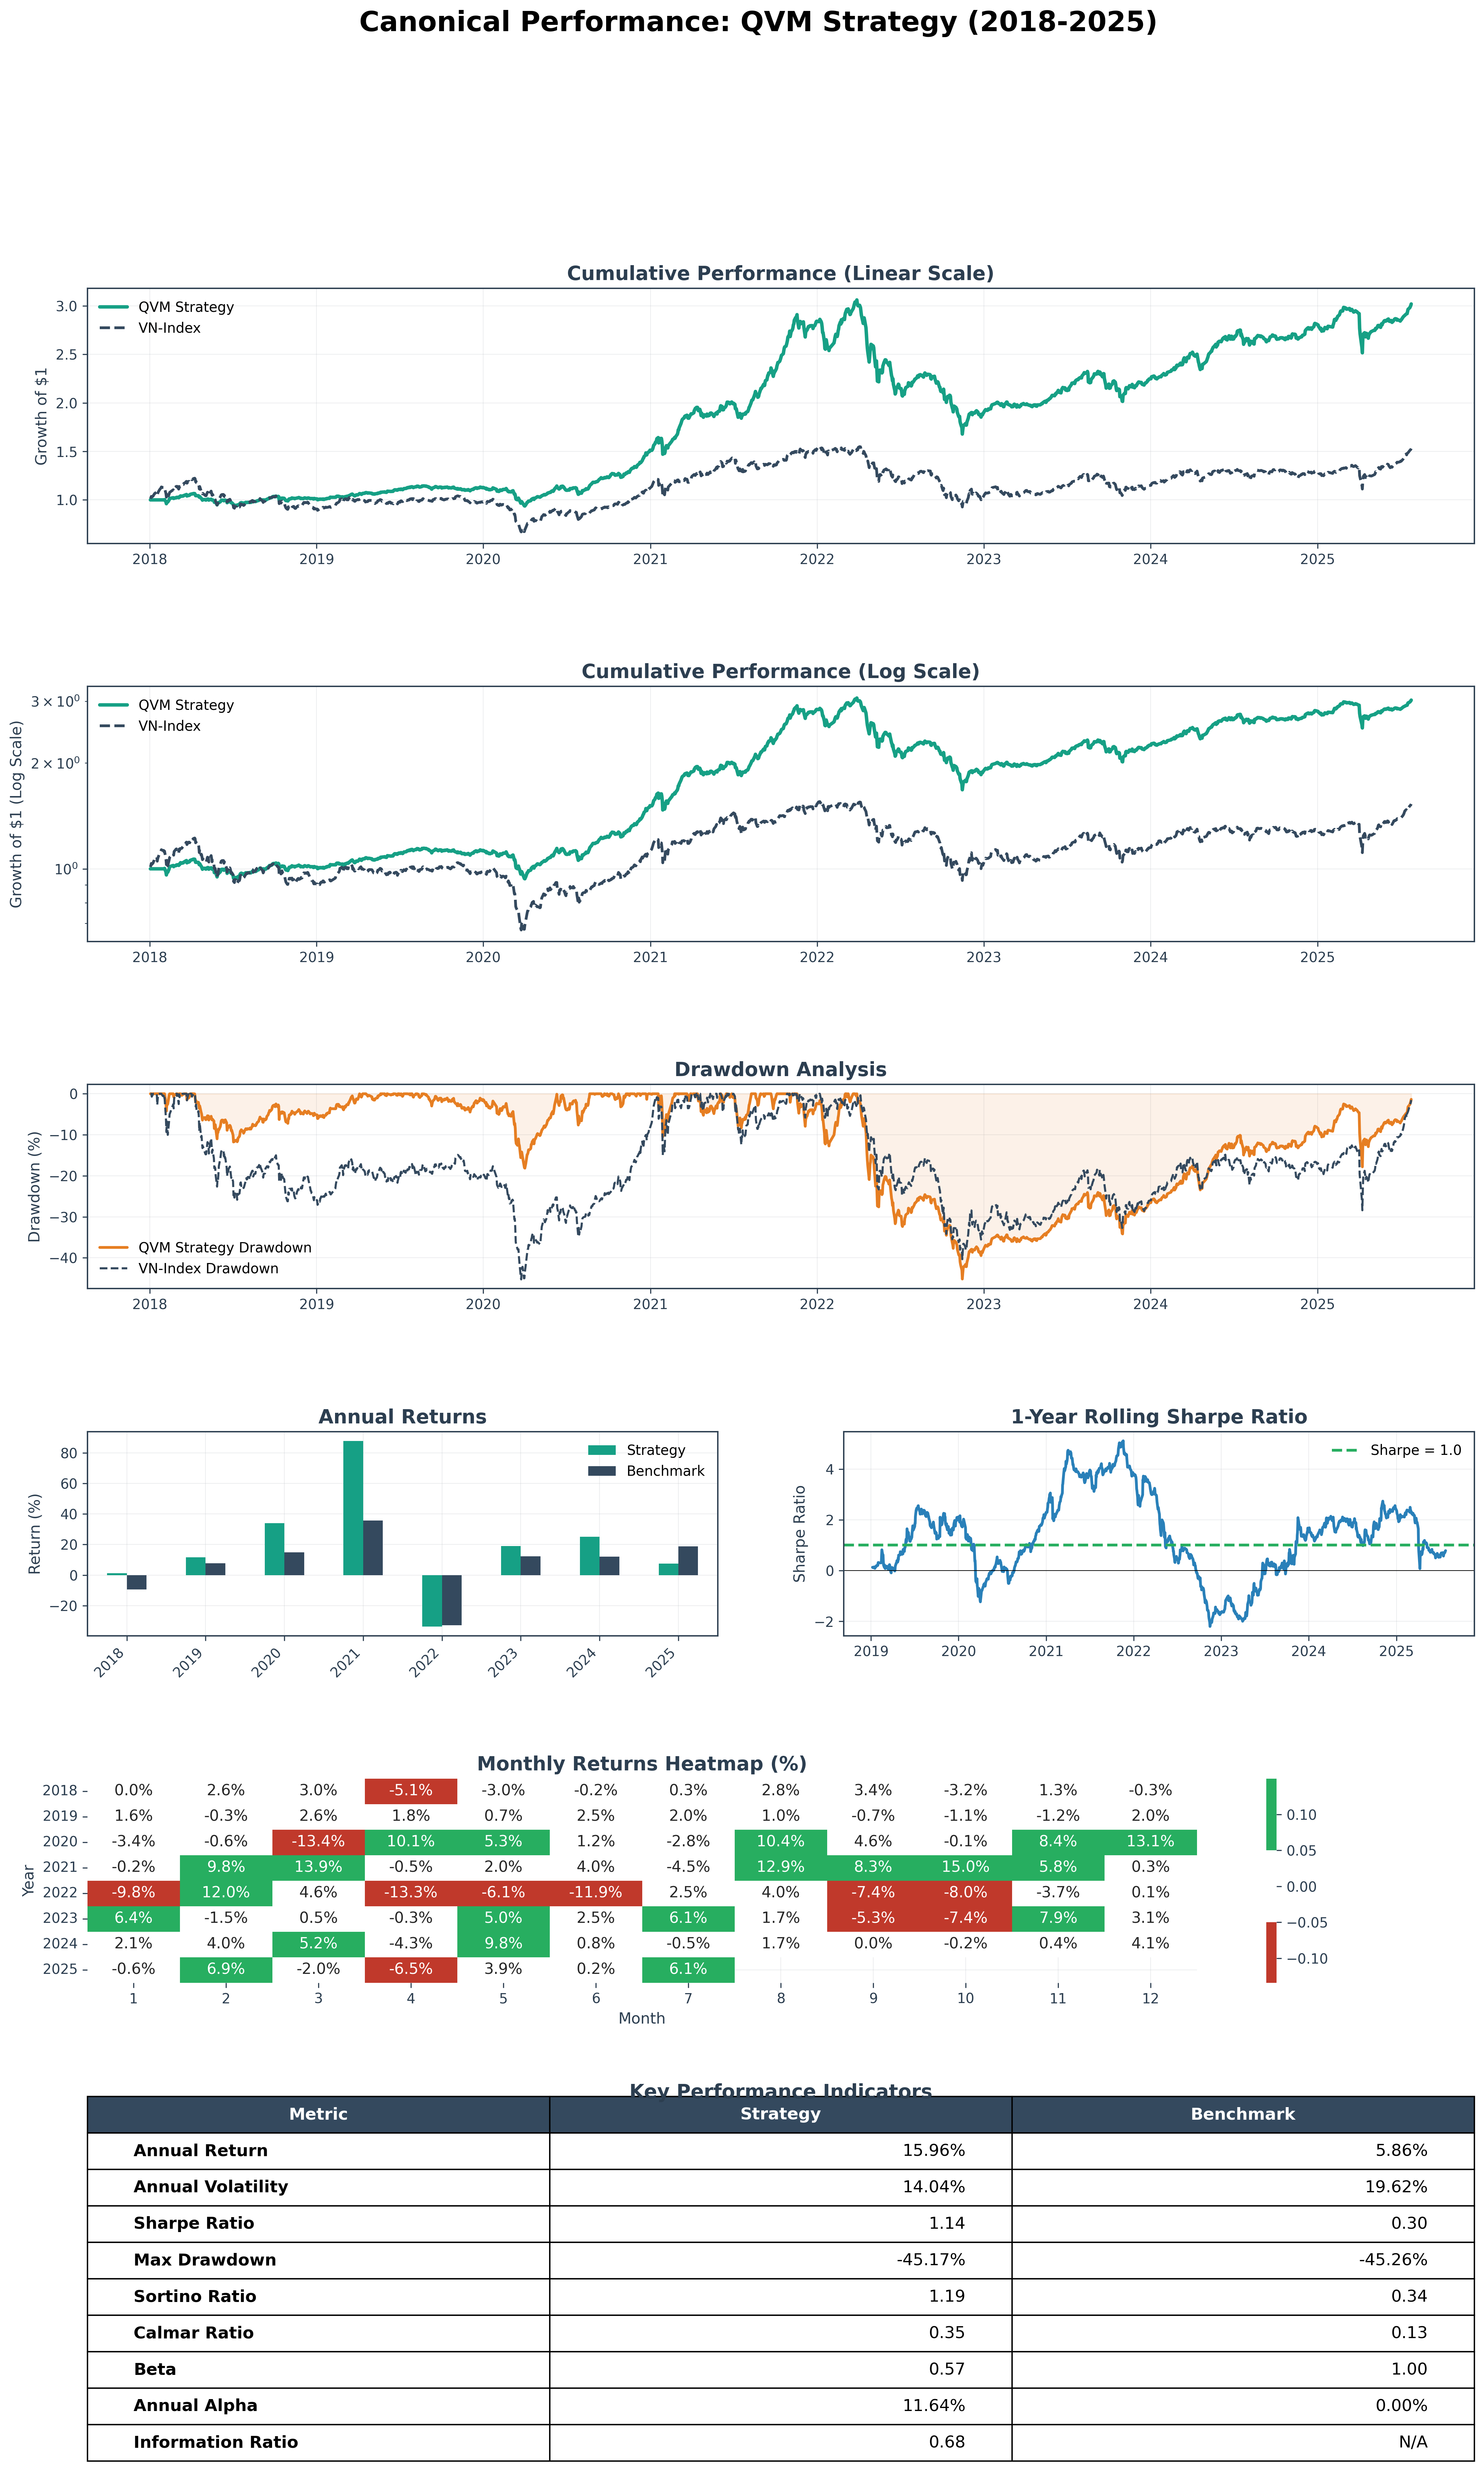


✅ Canonical tearsheet with institutional palette generated.


In [6]:
# ============================================================================
# CELL 5: PERFORMANCE ANALYSIS & VISUALIZATION (FINAL TEARSHEET)
# ============================================================================
# This final version produces the canonical tearsheet with the linear-scale
# equity curve as the primary chart, as requested.

print("📊 Calculating final performance metrics and generating the canonical tearsheet...")

# --- 1. Define Helper Function ---
def calculate_performance_metrics(
    returns: pd.Series, 
    benchmark: pd.Series, 
    risk_free_rate: float = 0.0
) -> Dict[str, float]:
    common_index = returns.index.intersection(benchmark.index)
    returns = returns.loc[common_index]
    benchmark = benchmark.loc[common_index]
    total_return = (1 + returns).prod() - 1
    n_years = len(returns) / 252
    annual_return = (1 + total_return) ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_vol if annual_vol > 0 else 0
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative / cumulative.cummax() - 1)
    max_drawdown = drawdown.min()
    downside_returns = returns[returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino_ratio = (annual_return - risk_free_rate) / downside_vol if downside_vol > 0 else 0
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    excess_returns = returns - benchmark
    tracking_error = excess_returns.std() * np.sqrt(252)
    information_ratio = (excess_returns.mean() * 252) / tracking_error if tracking_error > 0 else 0
    beta = returns.cov(benchmark) / benchmark.var() if benchmark.var() > 0 else 0
    alpha = annual_return - (risk_free_rate + beta * (benchmark.mean() * 252 - risk_free_rate))
    return {
        'Annual Return': annual_return * 100, 'Annual Volatility': annual_vol * 100,
        'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown * 100,
        'Sortino Ratio': sortino_ratio, 'Calmar Ratio': calmar_ratio,
        'Information Ratio': information_ratio, 'Beta': beta,
        'Annual Alpha': alpha * 100
    }

# --- 2. Calculate Final Performance Metrics ---
common_index = strategy_net_returns.index.intersection(benchmark_returns.index)
portfolio_aligned = strategy_net_returns.loc[common_index]
benchmark_aligned = benchmark_returns.loc[common_index]

portfolio_metrics = calculate_performance_metrics(portfolio_aligned, benchmark_aligned)
benchmark_metrics = calculate_performance_metrics(benchmark_aligned, benchmark_aligned)

# --- 3. Create Comprehensive Tearsheet ---
def create_canonical_tearsheet(strategy_returns, benchmark_returns, backtest_log, strategy_name="QVM Strategy"):
    fig = plt.figure(figsize=(18, 28))
    gs = fig.add_gridspec(6, 2, height_ratios=[1, 1, 0.8, 0.8, 0.8, 1.2], hspace=0.6, wspace=0.2)
    fig.suptitle(f'Canonical Performance: {strategy_name} (2018-2025)', fontsize=20, fontweight='bold')

    strategy_cum = (1 + strategy_returns).cumprod()
    benchmark_cum = (1 + benchmark_returns).cumprod()

    # --- Plot 1: Cumulative Performance (Linear Scale) ---
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(strategy_cum.index, strategy_cum, label=strategy_name, color=FACTOR_COLORS['Strategy'], linewidth=2.5)
    ax1.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=FACTOR_COLORS['Benchmark'], linestyle='--', linewidth=2)
    ax1.set_title('Cumulative Performance (Linear Scale)', fontweight='bold')
    ax1.set_ylabel('Growth of $1')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # --- Plot 2: Cumulative Performance (Log Scale) ---
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(strategy_cum.index, strategy_cum, label=strategy_name, color=FACTOR_COLORS['Strategy'], linewidth=2.5)
    ax2.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=FACTOR_COLORS['Benchmark'], linestyle='--', linewidth=2)
    ax2.set_yscale('log')
    ax2.set_title('Cumulative Performance (Log Scale)', fontweight='bold')
    ax2.set_ylabel('Growth of $1 (Log Scale)')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)

    # --- Plot 3: Drawdown Analysis ---
    ax3 = fig.add_subplot(gs[2, :])
    strategy_dd = (strategy_cum / strategy_cum.cummax() - 1) * 100
    benchmark_dd = (benchmark_cum / benchmark_cum.cummax() - 1) * 100
    ax3.plot(strategy_dd.index, strategy_dd, label=f'{strategy_name} Drawdown', color=FACTOR_COLORS['Drawdown'], linewidth=2)
    ax3.fill_between(strategy_dd.index, strategy_dd, 0, color=FACTOR_COLORS['Drawdown'], alpha=0.1)
    ax3.plot(benchmark_dd.index, benchmark_dd, label='VN-Index Drawdown', color=FACTOR_COLORS['Benchmark'], linestyle='--', linewidth=1.5)
    ax3.set_title('Drawdown Analysis', fontweight='bold')
    ax3.set_ylabel('Drawdown (%)')
    ax3.legend(loc='lower left')
    ax3.grid(True, alpha=0.3)

    # --- Plot 4: Annual Returns ---
    ax4 = fig.add_subplot(gs[3, 0])
    strat_annual = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    bench_annual = benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    annual_df = pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual})
    annual_df.plot(kind='bar', ax=ax4, color=[FACTOR_COLORS['Strategy'], FACTOR_COLORS['Benchmark']])
    ax4.set_xticklabels([d.strftime('%Y') for d in annual_df.index], rotation=45, ha='right')
    ax4.set_title('Annual Returns', fontweight='bold')
    ax4.set_ylabel('Return (%)')
    ax4.grid(True, alpha=0.3, axis='y')

    # --- Plot 5: Rolling Sharpe Ratio (1-Year) ---
    ax5 = fig.add_subplot(gs[3, 1])
    rolling_sharpe = (strategy_returns.rolling(252).mean() * 252) / (strategy_returns.rolling(252).std() * np.sqrt(252))
    ax5.plot(rolling_sharpe.index, rolling_sharpe, color=FACTOR_COLORS['Sharpe'])
    ax5.axhline(1.0, color=FACTOR_COLORS['Positive'], linestyle='--', label='Sharpe = 1.0')
    ax5.axhline(0.0, color='black', linestyle='-', linewidth=0.5)
    ax5.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold')
    ax5.set_ylabel('Sharpe Ratio')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # --- Plot 6: Monthly Returns Heatmap ---
    ax6 = fig.add_subplot(gs[4, :])
    monthly_returns = strategy_returns.resample('M').apply(lambda x: (1+x).prod()-1)
    monthly_pivot = monthly_returns.to_frame('ret').pivot_table(
        index=monthly_returns.index.year, columns=monthly_returns.index.month, values='ret'
    )
    sns.heatmap(monthly_pivot, ax=ax6, annot=True, fmt='.1%', cmap=sns.color_palette(GRADIENT_PALETTES['performance'], as_cmap=True), center=0)
    ax6.set_title('Monthly Returns Heatmap (%)', fontweight='bold')
    ax6.set_xlabel('Month')
    ax6.set_ylabel('Year')

    # --- Table: Performance Statistics ---
    ax7 = fig.add_subplot(gs[5, :])
    ax7.axis('off')
    
    summary_data = [
        ['Metric', 'Strategy', 'Benchmark'],
        ['Annual Return', f"{portfolio_metrics['Annual Return']:.2f}%", f"{benchmark_metrics['Annual Return']:.2f}%"],
        ['Annual Volatility', f"{portfolio_metrics['Annual Volatility']:.2f}%", f"{benchmark_metrics['Annual Volatility']:.2f}%"],
        ['Sharpe Ratio', f"{portfolio_metrics['Sharpe Ratio']:.2f}", f"{benchmark_metrics['Sharpe Ratio']:.2f}"],
        ['Max Drawdown', f"{portfolio_metrics['Max Drawdown']:.2f}%", f"{benchmark_metrics['Max Drawdown']:.2f}%"],
        ['Sortino Ratio', f"{portfolio_metrics['Sortino Ratio']:.2f}", f"{benchmark_metrics['Sortino Ratio']:.2f}"],
        ['Calmar Ratio', f"{portfolio_metrics['Calmar Ratio']:.2f}", f"{benchmark_metrics['Calmar Ratio']:.2f}"],
        ['Beta', f"{portfolio_metrics['Beta']:.2f}", "1.00"],
        ['Annual Alpha', f"{portfolio_metrics['Annual Alpha']:.2f}%", "0.00%"],
        ['Information Ratio', f"{portfolio_metrics['Information Ratio']:.2f}", "N/A"],
    ]
    
    table = ax7.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2.2)
    for i in range(len(summary_data)):
        for j in range(len(summary_data[0])):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor(FACTOR_COLORS['Benchmark'])
                cell.set_text_props(weight='bold', color='white')
            elif j == 0:
                cell.set_text_props(weight='bold', ha='left')
            else:
                cell.set_text_props(ha='right')

    ax7.set_title('Key Performance Indicators', fontweight='bold', fontsize=14, pad=20)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Generate the final tearsheet
create_canonical_tearsheet(portfolio_aligned, benchmark_aligned, backtest_log)

print("\n✅ Canonical tearsheet with institutional palette generated.")